[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


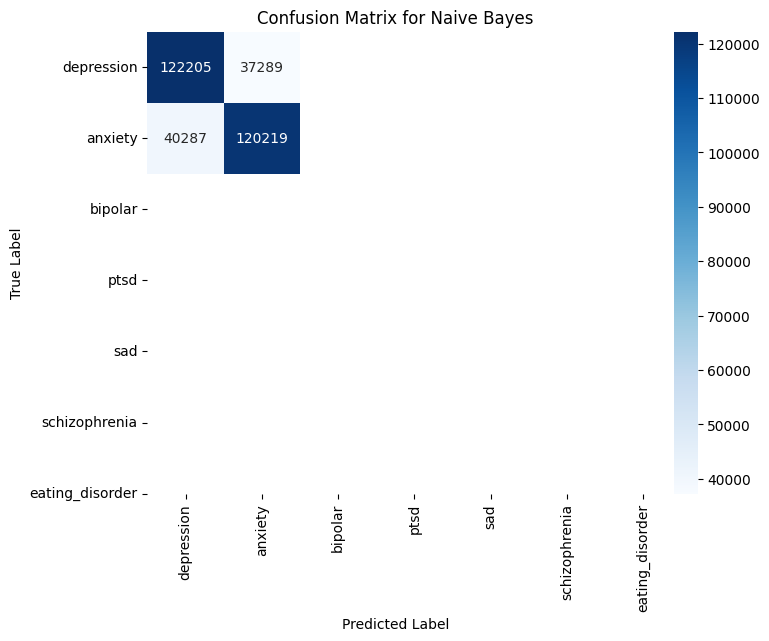

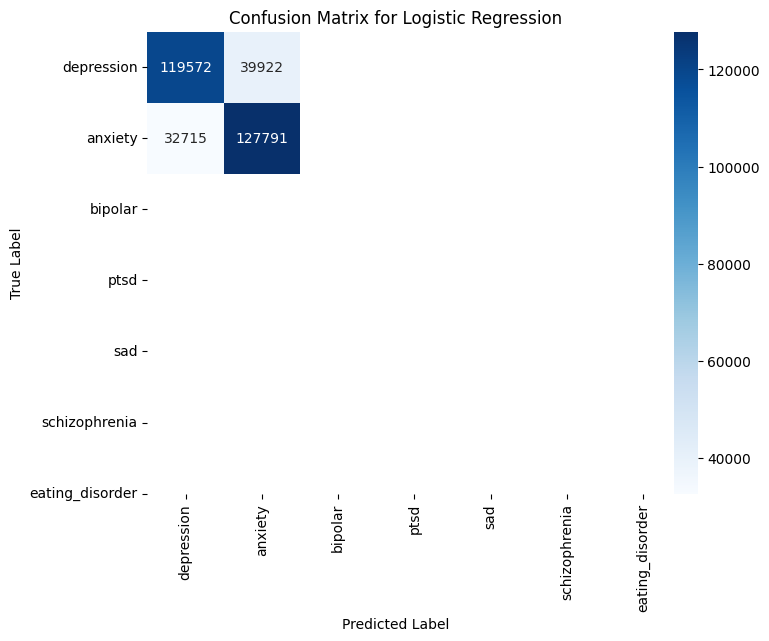

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


nltk.download("stopwords")

# Load Sentiment140 Dataset
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin-1", header=None)

# Assign Column Names
df.columns = ["sentiment", "id", "date", "query", "user", "text"]
df = df[["sentiment", "text"]]


mental_health_labels = {
    0: "depression",
    1: "anxiety",
    2: "bipolar",
    3: "ptsd",
    4: "sad",
    5: "schizophrenia",
    6: "eating_disorder"
}

df["label"] = df["sentiment"].map(mental_health_labels)


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"\@w+|\#\w+", "", text)  # Remove mentions and hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = text.replace("\n", " ")  # Remove new lines
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])  # Remove stopwords
    return text


df["clean_text"] = df["text"].apply(clean_text)


vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])


df["label_encoded"] = df["label"].astype("category").cat.codes
y = df["label_encoded"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel="linear")
}


results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({"Model": name, "Accuracy": accuracy, "Precision": report["weighted avg"]["precision"],
                    "Recall": report["weighted avg"]["recall"], "F1-Score": report["weighted avg"]["f1-score"]})
    
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=mental_health_labels.values(), yticklabels=mental_health_labels.values())
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


results_df = pd.DataFrame(results)
print(results_df)


plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Comparison (Accuracy)")
plt.show()
